In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
sys.path.insert(0, "../../")  # Добавляем родительскую директорию в `path`, чтобы python смог найти наши модули

In [2]:
import os

In [109]:
# Проверим, что python теперь их видит:
from modules.impute import InterpolationImputer

ModuleNotFoundError: No module named 'modules'

<div class="alert alert-info">
  <h1><center>Data (2 балла)</center></h1></div>

In [150]:
df = pd.read_csv("train.csv", low_memory=False)
df.columns = map(str.lower, df.columns)
df_copy = df.copy()
df

,id,year,loan_limit,gender,approv_in_adv,loan_type,loan_purpose,credit_worthiness,open_credit,business_or_commercial,...,income,credit_type,credit_score,co-applicant_credit_type,age,submission_of_application,ltv,region,security_type,status
0,89268,2019,cf,Joint,nopre,type1,p4,l1,nopc,nob/c,...,7380.0,EXP,512,EXP,65-74,to_inst,70.292208,North,direct,0
1,125974,2019,cf,Joint,nopre,type1,p1,l1,nopc,nob/c,...,8580.0,EXP,588,EXP,35-44,not_inst,80.013193,North,direct,0
2,62363,2019,cf,Female,nopre,type1,p1,l1,nopc,nob/c,...,4860.0,CRIF,801,EXP,35-44,to_inst,99.050633,North,direct,1
3,106793,2019,cf,Sex Not Available,nopre,type1,p4,l1,nopc,nob/c,...,6000.0,EQUI,798,EXP,35-44,to_inst,NaN,south,direct,1
4,66272,2019,cf,Joint,nopre,type1,p3,l1,nopc,nob/c,...,10500.0,CRIF,554,EXP,>74,not_inst,69.295302,North,direct,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118931,110475,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,7200.0,CRIF,728,EXP,55-64,to_inst,92.534722,North,direct,0
118932,30229,2019,cf,Sex Not Available,nopre,type3,p3,l1,nopc,nob/c,...,3180.0,CIB,656,CIB,>74,to_inst,65.625000,south,direct,0
118933,141826,2019,cf,Male,pre,type2,p4,l1,nopc,b/c,...,2700.0,EXP,682,CIB,65-74,to_inst,58.445946,North,direct,1
118934,120759,2019,cf,Sex Not Available,pre,type1,p3,l1,nopc,nob/c,...,3840.0,CIB,871,CIB,55-64,to_inst,68.503289,south,direct,0


In [151]:
df_copy['construction_type'].loc[df_copy['secured_by'] == 'land'].value_counts()

mh    24
Name: construction_type, dtype: int64

#### удаление колонок

###### year
он у всех один в этой колонке нет смысла

In [152]:
df_copy = df_copy.drop('year', axis=1)
df_copy = df_copy.set_index('id')

##### security_type, secured_by, construction_type
у этих колонок одинаковое кол-во определенных значений, при этом эти значения пренадлежат одним и тем же людям. Соотвпетсвенно можно удалить любые 2 из них, т.к они по сути копируют друг друга

In [153]:
df_copy = df_copy.drop('construction_type', axis=1)
df_copy = df_copy.drop('secured_by', axis=1)

#### interest_rate_spread, rate_of_interest
они обсолютно влияют на прогноз статуса, поэтому мы их выкенем

In [154]:
df_copy = df_copy.drop('rate_of_interest', axis=1)
df_copy = df_copy.drop('interest_rate_spread', axis=1)

In [155]:
X = df_copy.drop(columns=["status"])
Y = df_copy["status"]

In [156]:
y.value_counts()

0    89625
1    29311
Name: status, dtype: int64

### Train | Test split

Разбейте датасет на тренировочный и тестовый (оставьте 20% для теста, не забудтье зафиксировать random_seed)

In [157]:
from sklearn.model_selection import train_test_split

In [158]:
# cids = sorted(set(y.index.get_level_values("status")))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,  test_size=0.2, random_state=42)

### First look and general info

Отобразите базовую информацию о датасете: размер, тип данных, базовые статистики

In [159]:
for col_name, col_value in X_train.items():
    print(col_name)
    print(f'Type of column: {col_value.dtype}')
    print(f'Is unique: {col_value.is_unique}')
    print(f'% of na: {col_value.isna().mean()}')
    display(col_value.value_counts())
    print('-'*100, end='\n\n')

loan_limit
Type of column: object
Is unique: False
% of na: 0.023006263925673686


cf     86513
ncf     6446
Name: loan_limit, dtype: int64

----------------------------------------------------------------------------------------------------

gender
Type of column: object
Is unique: False
% of na: 0.0


Male                 27176
Joint                26435
Sex Not Available    24020
Female               17517
Name: gender, dtype: int64

----------------------------------------------------------------------------------------------------

approv_in_adv
Type of column: object
Is unique: False
% of na: 0.006022196998360449


nopre    79781
pre      14794
Name: approv_in_adv, dtype: int64

----------------------------------------------------------------------------------------------------

loan_type
Type of column: object
Is unique: False
% of na: 0.0


type1    72377
type2    13217
type3     9554
Name: loan_type, dtype: int64

----------------------------------------------------------------------------------------------------

loan_purpose
Type of column: object
Is unique: False
% of na: 0.000851305334846765


p3    35636
p4    35144
p1    22132
p2     2155
Name: loan_purpose, dtype: int64

----------------------------------------------------------------------------------------------------

credit_worthiness
Type of column: object
Is unique: False
% of na: 0.0


l1    91124
l2     4024
Name: credit_worthiness, dtype: int64

----------------------------------------------------------------------------------------------------

open_credit
Type of column: object
Is unique: False
% of na: 0.0


nopc    94781
opc       367
Name: open_credit, dtype: int64

----------------------------------------------------------------------------------------------------

business_or_commercial
Type of column: object
Is unique: False
% of na: 0.0


nob/c    81931
b/c      13217
Name: business_or_commercial, dtype: int64

----------------------------------------------------------------------------------------------------

loan_amount
Type of column: int64
Is unique: False
% of na: 0.0


206500     2915
256500     2622
226500     2535
156500     2508
486500     2434
           ... 
1526500       1
1646500       1
1826500       1
1566500       1
2226500       1
Name: loan_amount, Length: 204, dtype: int64

----------------------------------------------------------------------------------------------------

upfront_charges
Type of column: float64
Is unique: False
% of na: 0.267183755833018


0.00       13399
1250.00      744
1150.00      567
795.00       312
295.00       270
           ...  
3264.28        1
590.96         1
3731.69        1
1498.63        1
2656.89        1
Name: upfront_charges, Length: 39317, dtype: int64

----------------------------------------------------------------------------------------------------

term
Type of column: float64
Is unique: False
% of na: 0.00027325850254340605


360.0    77966
180.0     8302
240.0     3684
300.0     1806
324.0     1738
120.0      318
144.0      185
348.0      159
336.0      151
312.0      123
96.0       122
156.0      105
216.0       74
276.0       67
132.0       63
288.0       55
228.0       51
168.0       51
204.0       38
264.0       30
108.0       18
192.0        9
252.0        6
165.0        1
Name: term, dtype: int64

----------------------------------------------------------------------------------------------------

neg_ammortization
Type of column: object
Is unique: False
% of na: 0.0007777357380081557


not_neg    85366
neg_amm     9708
Name: neg_ammortization, dtype: int64

----------------------------------------------------------------------------------------------------

interest_only
Type of column: object
Is unique: False
% of na: 0.0


not_int     90512
int_only     4636
Name: interest_only, dtype: int64

----------------------------------------------------------------------------------------------------

lump_sum_payment
Type of column: object
Is unique: False
% of na: 0.0


not_lpsm    92966
lpsm         2182
Name: lump_sum_payment, dtype: int64

----------------------------------------------------------------------------------------------------

property_value
Type of column: float64
Is unique: False
% of na: 0.10274519695632069


3.080000e+05    1809
2.580000e+05    1727
3.580000e+05    1711
3.280000e+05    1622
4.080000e+05    1608
                ... 
2.702317e+11       1
1.605537e+09       1
2.551385e+10       1
3.038000e+06       1
3.005512e+08       1
Name: property_value, Length: 429, dtype: int64

----------------------------------------------------------------------------------------------------

occupancy_type
Type of column: object
Is unique: False
% of na: 0.0


pr    88518
ir     4612
sr     2018
Name: occupancy_type, dtype: int64

----------------------------------------------------------------------------------------------------

total_units
Type of column: object
Is unique: False
% of na: 0.0


1U    93774
2U      930
3U      235
4U      209
Name: total_units, dtype: int64

----------------------------------------------------------------------------------------------------

income
Type of column: float64
Is unique: False
% of na: 0.06193509059570353


0.0        848
3600.0     805
4200.0     800
4800.0     779
3720.0     763
          ... 
95820.0      1
36060.0      1
52140.0      1
77760.0      1
54900.0      1
Name: income, Length: 878, dtype: int64

----------------------------------------------------------------------------------------------------

credit_type
Type of column: object
Is unique: False
% of na: 0.0


CIB     30649
CRIF    28172
EXP     26425
EQUI     9902
Name: credit_type, dtype: int64

----------------------------------------------------------------------------------------------------

credit_score
Type of column: object
Is unique: False
% of na: 0.0


687     279
864     271
890     269
834     269
554     269
       ... 
_576      1
640_      1
_675      1
_801      1
71_2      1
Name: credit_score, Length: 409, dtype: int64

----------------------------------------------------------------------------------------------------

co-applicant_credit_type
Type of column: object
Is unique: False
% of na: 0.0


EXP    47645
CIB    47503
Name: co-applicant_credit_type, dtype: int64

----------------------------------------------------------------------------------------------------

age
Type of column: object
Is unique: False
% of na: 0.0013242527430949679


45-54    22256
35-44    20981
55-64    20828
65-74    13235
25-34    12282
>74       4583
<25        857
Name: age, dtype: int64

----------------------------------------------------------------------------------------------------

submission_of_application
Type of column: object
Is unique: False
% of na: 0.0013242527430949679


to_inst     61171
not_inst    33851
Name: submission_of_application, dtype: int64

----------------------------------------------------------------------------------------------------

ltv
Type of column: float64
Is unique: False
% of na: 0.10274519695632069


81.250000    328
91.666667    327
80.038760    227
80.032468    216
78.846154    213
            ... 
36.094848      1
33.635647      1
27.607285      1
62.524558      1
24.969287      1
Name: ltv, Length: 7117, dtype: int64

----------------------------------------------------------------------------------------------------

region
Type of column: object
Is unique: False
% of na: 0.0


North         47936
south         40791
central        5635
North-East      786
Name: region, dtype: int64

----------------------------------------------------------------------------------------------------

security_type
Type of column: object
Is unique: False
% of na: 0.0


direct      95128
Indriect       20
Name: security_type, dtype: int64

----------------------------------------------------------------------------------------------------



### Data types normalization

Проверьте, все ли признаки имеют правильный тип данных?

### credit_score
у кредит скор тип object в то время как ему следует быть числовым, также у него есть значения с _ которые надо исправить 
### total_units
имеет object type, вида intU, преобразуем его просто в int, т.к будем считать, что total units означает кол-во товаров/услуг то есть их можно сравнить по кол-ву и в нашем случае 4U больше чем 3U 
для этих двух легко можно воспользоваться одним способом(да я знаю что в total_units можно просто написать .str[0]), но я решил сделать одним RegexTransformer-ом

### так называемый RegexTransformer для колонок total_units and credit_score

In [160]:
from typing import List
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted


class CustomTransformer(BaseEstimator, TransformerMixin):

    def __init__(self) -> None:
        self.feature_names_in_: List[str]
        self.n_features_ : int
        self.is_fitted_: bool

    def fit(self, X, y=None, **params) -> 'CustomTransformer':
        self.feature_names_in_ = list(X.columns)
        self.n_features_ = X.shape[1]
        self.is_fitted_ = True
        return self

    def transform(self, X, copy: bool = False, **params):
        check_is_fitted(self, 'is_fitted_')
        if copy:
            X = X.copy()
        return X

    def get_feature_names_out(self, input_features=None) -> List[str]:
        return self.feature_names_in_

In [161]:
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Optional


class RegexTransformer(CustomTransformer):
    
    def __init__(self, regex: str, target_dtype: Optional[type]):
        self.regex = regex
        self.target_dtype = target_dtype
    
    def transform(self, X: pd.DataFrame, **kwargs) -> pd.DataFrame: 
        X = super().transform(X)
        for col_name in X.columns:
            X[col_name] = X[col_name].str.findall(self.regex).map(lambda x: ''.join(x)).astype(self.target_dtype)
        return X

### Extreme values detection

Проверьте, есть ли аномальные данные? Постройте базовые визуализации там, где это уместно

In [162]:
def visualization(X: pd.DataFrame):
    for col_name, col_values in X.items():
        fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(11.5, 12))
        _ = ax0.boxplot(col_values.dropna(), labels=[""], vert=False, widths=0.8, showmeans=True)
        _ = ax1.boxplot(col_values.dropna(), labels=[""], vert=False, widths=0.8, showmeans=True)
        ax0.set(title=f"boxplot of {col_name}")
        ax1.set(title=f"boxplot of {col_name}, log axes", xscale="log")
        plt.show()

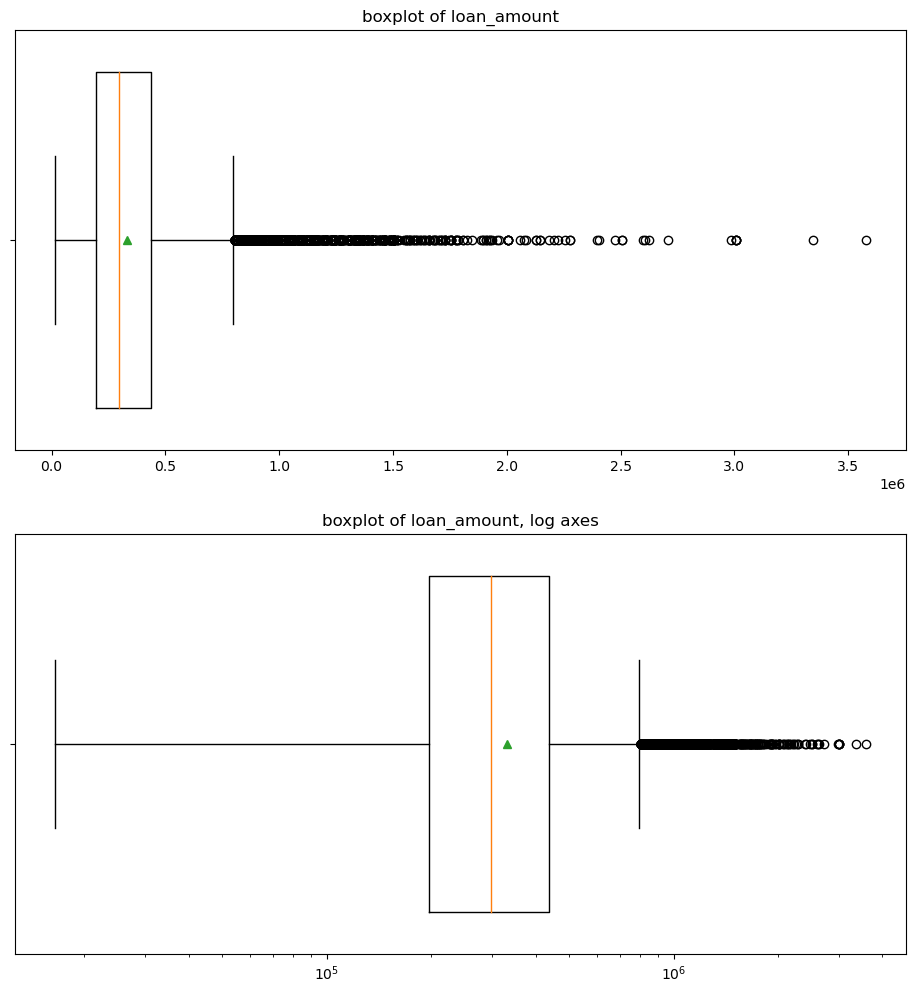

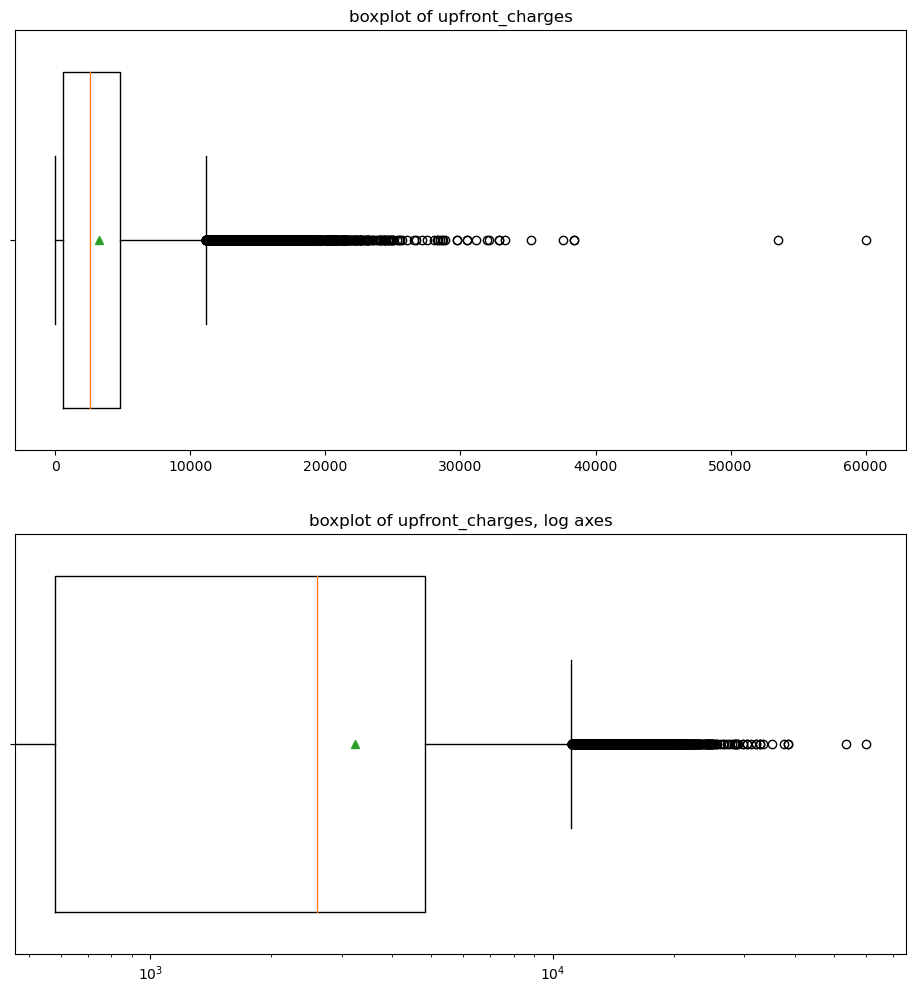

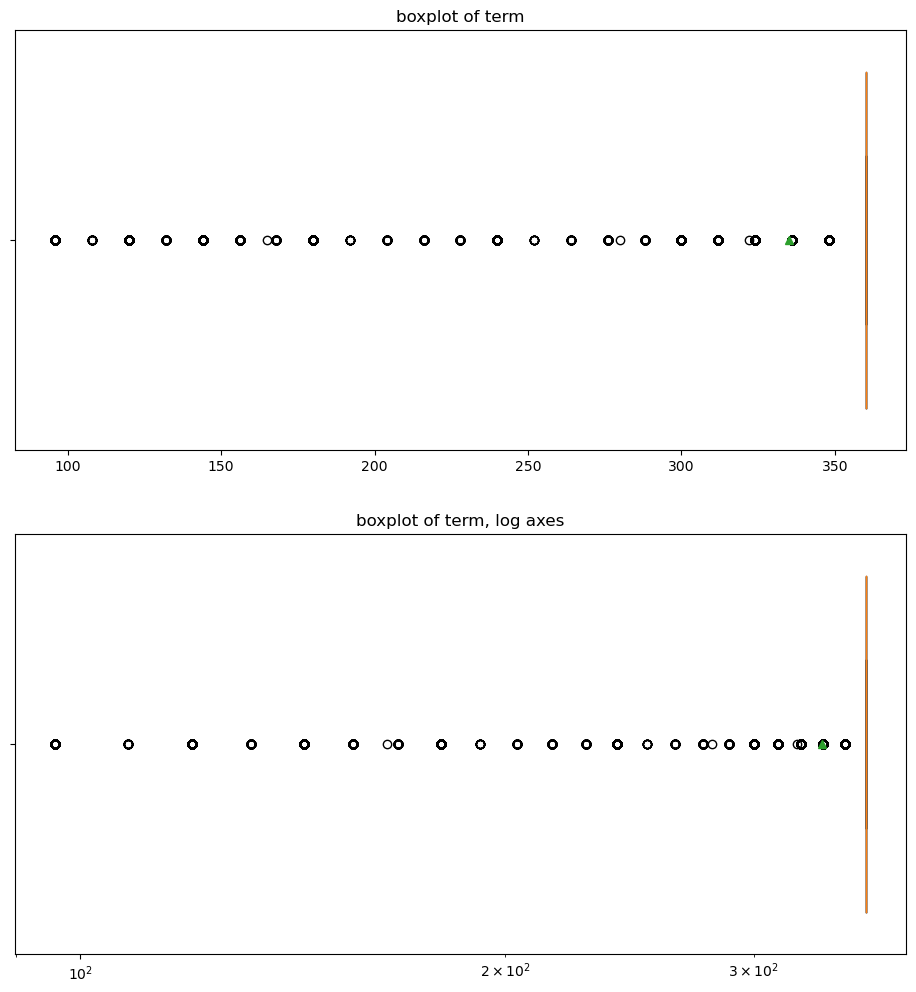

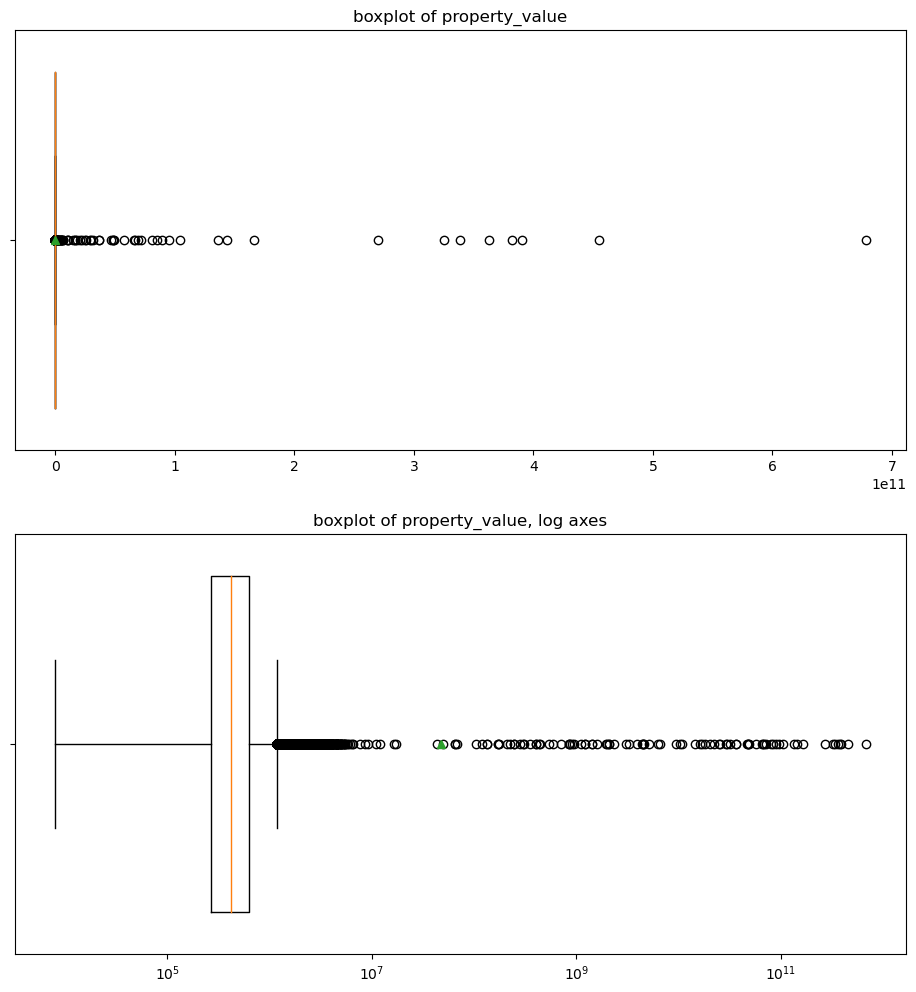

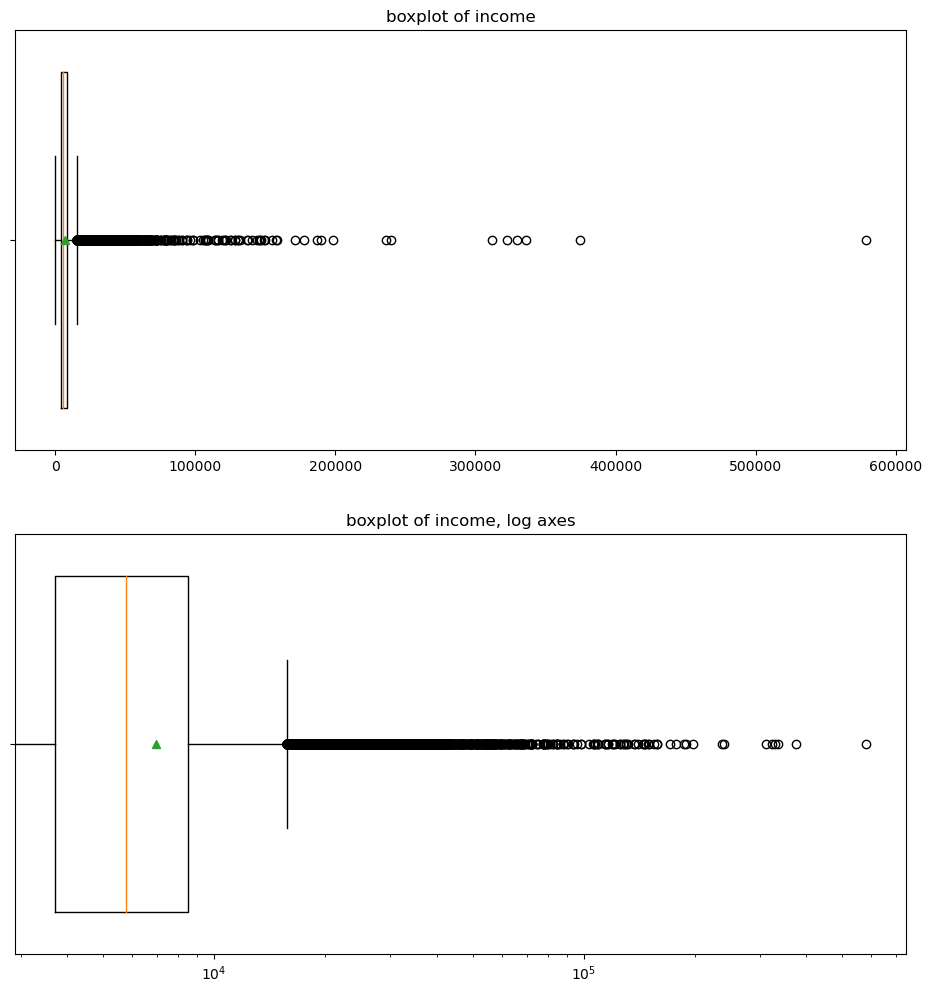

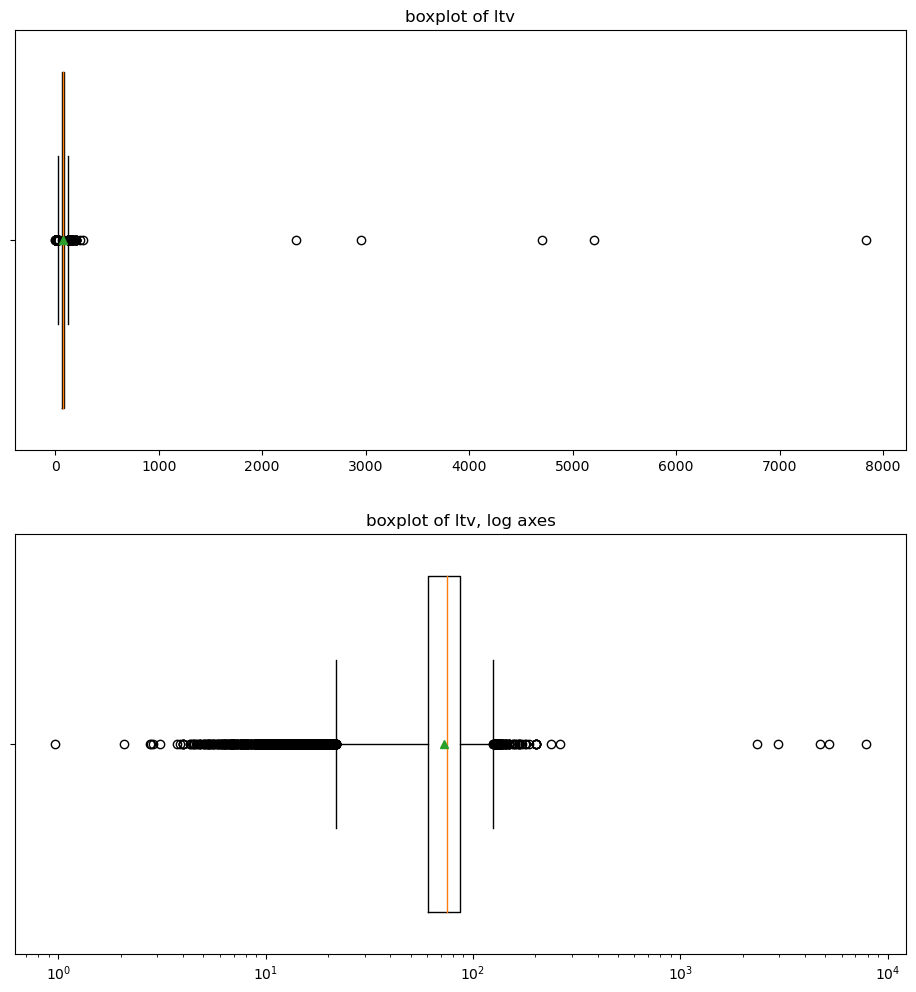

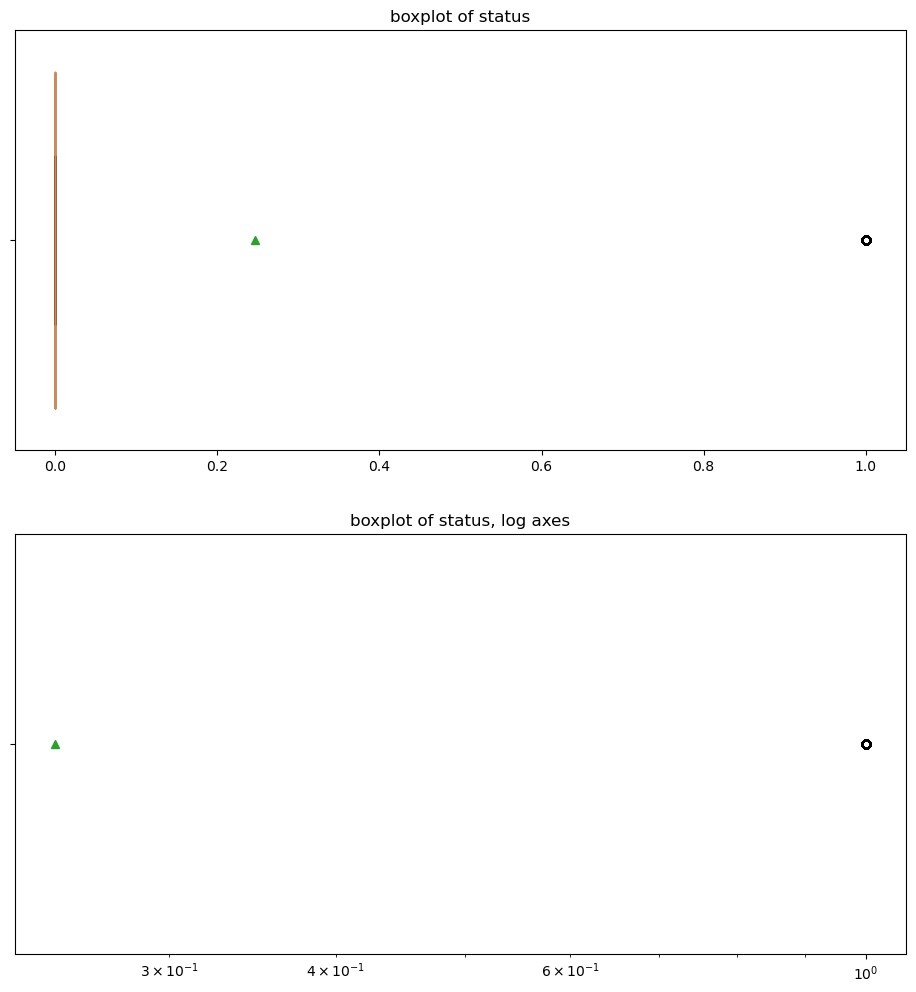

In [163]:
visualization(df_copy.select_dtypes(np.number))

In [164]:
df_copy['loan_amount'].loc[df_copy['income'] > 70000]

id
139727     536500
85031      486500
35554      446500
77620     1336500
149538     326500
           ...   
84908      936500
141519     726500
74639      656500
139449     446500
156617     436500
Name: loan_amount, Length: 94, dtype: int64

### Missing values detection

Есть ли пропущенные данные?

---

<div class="alert alert-info">
  <h1><center>Preprocessing (3 балла)</center></h1></div>

# <center>Numerical features</center>

### Deal with extreme values

Напишите / используйте функции / трансформеры, которые будут "исправлять" экстримальные значения (какой способ лучше подходит? почему?)

### rate_of_interest
насколько я понял это колонка показывает ставку в процентах. впринципе есть значения довольно большие по типу 6-8%,
также есть 0%, но вроде как и 0 и 6-8% могут быть, это как раз единичные случаи, так что в этой колонке нет аутлаеров,
я так считаю


### interest_rate_spread
это вроде разница между двумя ставками в процентах, то есть и отрицательные, и положительные значения являются нормой.
Можно сказать что -3% довольно большая разница, но я проверил и увидел что эти -3% как раз у того человека, у которого значение rate_of_interest равно 0%. Следовательно ничего аномального в этом значении нет.


### property_value 
стоимость недвижимости. Опять же она может быть почти сколь угодно большой. Но я посчитал, что все значения большие 10^9 я клипну к максимальному(даже если эти значения впринципе могут быть), а минимальное значение для клипа будет естественно 0, так как впринципе ниже 0 стоимость недвижимости не может быть, а 0 легко объясняется отсутствием недвижимости


### upfront_charges
стоимость залога. Максимальное значение 60000. Опять же не такое огромное значение, чтобы 100% сказать ну такого быть не может(естественно сравнивая с property_value). Так что оставлю все как есть


### term
тут очевидно нет никаких экстремальных значений


### ltv 
не очень понял что это. В интернете было 2 варианта. Один говорит что это относится к банку, но тогда должно быть выражено в процентах, второй вариант говорит, что это не оч относится к банку, но я все равно не знаю какие значение тут экстремальные. Но судя по графику все, что больше 300 можно клипунть.


### credit_score 
тут ничего делать не надо


остались две самые интересные колонки loan_amount and income. Которые в каком-то смысле должны зависить друг от друга.
Какой смысл брать человеку кредит в 1 миллион, при доходе в 600000. Но не мне решать есть ли в этом смысл или нет.
Поэтому оставлю все как есть

#### ClipTransformer


In [165]:
class ClipTransfromer(CustomTransformer):
    
    def __init__(self, min_value: float, max_value: float):
        self.min_value = min_value
        self.max_value = max_value
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = super().transform(X)
        for col_name in X.columns:
            X[col_name].loc[X[col_name] < self.min_value] = self.min_value
            X[col_name].loc[X[col_name] > self.max_value] = self.max_value
        return X

In [166]:
# df_copy['property_value'].loc[df_copy['property_value'] > 200000000] = 0
from sklearn.preprocessing import FunctionTransformer
clipper = FunctionTransformer(lambda x: pd.Series.clip(x, lower=0, upper=7000000), validate=False)
df_copy['property_value'] = clipper.transform(df['property_value'])
df_copy['property_value'].value_counts()

308000.0     1434
258000.0     1413
358000.0     1377
328000.0     1291
268000.0     1289
             ... 
4408000.0       1
3218000.0       1
5208000.0       1
3128000.0       1
3848000.0       1
Name: property_value, Length: 329, dtype: int64

### Deal with missing values

Напишите/используйте функции/трансформеры для заполнения пропущенных значений. Какова логика? Напишите краткое пояснение, почему Вы выбрали тот или иной подход

впринципе я хотел заполнить пропущенные значения исходя из распределения в этом же столбце и добавить столбец-индикатор. Но можно просто заполнить невозможными для этих столбцов значениями. Причем одно знаечние для каждого столбика.

####  property_value, income, rate_of_interest, ltv, upfront_charges
заполняем все наны -1. 


#### term 
заполним самым встречающимся значением, так как оно составляет порядка 80% и значение не мало.


#### interest_rate_spread
заполняем очень большим значением, так как очевидно знаечние разницы процентов не может быть больше 100.

### term 

In [167]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=df_copy['term'].value_counts().idxmax())
df['col'] = imp.fit_transform(df['col'])

KeyError: 'col'

In [ ]:
df_copy['term'].isna().mean()

In [ ]:
print(df_copy.columns)
X.columns


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


preprocessing_transformer = ColumnTransformer(
    transformers=[
                    (
                        'to_numeric',
                        RegexTransformer(regex=r'[0-9]+', target_dtype=int),
                        ['credit_score', 'total_units']
                    )
                ],
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")


outlier_transformer = ColumnTransformer(
    transformers=[
                        (
                            'clip1',
                            ClipTransfromer(min_value=0, max_value=1000000000),
                            ['property_value']
                        ),
                        (
                           'clip2',
                            ClipTransfromer(min_value=0, max_value=300),
                            ['ltv'] 
                        )       
                ],
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")
 
    
    
fillna_transformer = ColumnTransformer(
    transformers=[
                        (
                            'fill_with_-1',
                            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1),
                            ['property_value', 'income', 'ltv', 'upfront_charges']
                        ),
                        (
                            'fill_with_most_frequent',
                            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                            ['term']
                        )
                ],
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")


X = preprocessing_transformer.fit_transform(df_copy)
X = outlier_transformer.fit_transform(X)
X = fillna_transformer.fit_transform(X)


# <center>Categorical Features</center>

Какие признаки и как Вы будете кодировать?

### Encode nominal featuers

# категориальные признаки

#### loan_limit
впринципе спокойно можно кодировать onehot

#### gender 
по идее можно joint закодировать как 1 в male и 1 в female

#### approv_in_adv
спокойно можно кодировать onehot

#### loan_type
тут тоже можно onehot

#### loan_purpose
казалось бы очень похоже на total_units вроде как loan purpose означает цель кредита и цели нельзя сравнивать по величине(хотя вроде и можно если учитывать, что цели отличаются кол-вом денег, но у нас неизвестно какой вид из p1, p2, p3, p4 какой сумме денег соответсвует). Поэтому onehot

#### credit_worthiness
кредитоспособность тоже вроде нельзя сравнить сказав, что l1 больше или меньше l2. Поэтому тоже onehot

#### open_credit
onehot

#### business_or_commercial
onehot

#### neg_ammortization
onehot

#### interest_only
onehot


#### occupancy_type
onehot


#### credit_type
onehot

#### co-applicant_credit_type
onehot

#### age
onehot, но может быть еще добавить колоночку 18-24

#### submission_of_application
onehot

#### region
onehot

#### security_type
onehot

#### lump_sum_payment
onehot

In [ ]:
from sklearn.preprocessing import OneHotEncoder


categorial_features = ColumnTransformer(
    transformers=[
                    (
                        'onehot',
                        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
                        [
                            'security_type', 'region', 'submission_of_application', 'co-applicant_credit_type',
                            'credit_type', 'occupancy_type', 'interest_only',
                            'neg_ammortization', 'business_or_commercial', 'open_credit', 'loan_type', 'approv_in_adv',
                            'loan_limit', 'gender', 'age', 'credit_worthiness', 'loan_purpose','lump_sum_payment'
                        ]
                    )
                ],
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

### Encode ordinal features

---

<div class="alert alert-info">
  <h1><center>Pipeline (3 балла)</center></h1></div>

Соберите pipeline, который будет реализовывать все предыдущие трансформации

In [168]:
from sklearn.pipeline import Pipeline

In [169]:
pipe = Pipeline(
                steps=[
                        ('preprocessing_transformer', preprocessing_transformer),
                        ('outlier_transformer', outlier_transformer),
                        ('fillna_transformer', fillna_transformer),
                        ('categorial_transformer', categorial_features)
                    ],
                verbose=True
            ).set_output(transform="pandas")

In [170]:
X_train = pipe.fit_transform(X_train)
X_test = pipe.fit_transform(X_test)

[Pipeline]  (step 1 of 4) Processing preprocessing_transformer, total=   0.9s
[Pipeline]  (step 2 of 4) Processing outlier_transformer, total=   0.1s
[Pipeline]  (step 3 of 4) Processing fillna_transformer, total=   0.2s
[Pipeline]  (step 4 of 4) Processing categorial_transformer, total=   0.9s
[Pipeline]  (step 1 of 4) Processing preprocessing_transformer, total=   0.1s
[Pipeline]  (step 2 of 4) Processing outlier_transformer, total=   0.0s
[Pipeline]  (step 3 of 4) Processing fillna_transformer, total=   0.1s
[Pipeline]  (step 4 of 4) Processing categorial_transformer, total=   0.2s


<div class="alert alert-info">
  <h1><center>Model (2 балла)</center></h1></div>

Выберите любую из пройденных моделей и примените её к обработанному датасету

In [174]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [175]:
rfc = RandomForestClassifier(random_state=1, max_depth=6, min_samples_leaf=50)
rfc.fit(X_train, Y_train)
rfc.score(X_test, Y_test)
benchmark_classifier.fit(X_train, Y_train)
y_pred_benchmark = benchmark_classifier.predict(X_test)
print(classification_report(Y_test, y_pred_benchmark))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     18015
           1       0.93      1.00      0.96      5773

    accuracy                           0.98     23788
   macro avg       0.97      0.99      0.98     23788
weighted avg       0.98      0.98      0.98     23788



Оцените модель при помощи изученных метрик

Что можно сделать, чтобы оптимизировать полученную модель?

---

# <center>Удачи!</center>